## Price Prediction of Bitcoin

In [1]:
import numpy as np
import pandas as pd
import os

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
!pip install -U -q mlflow

In [3]:
data = pd.read_csv("/content/BTC-USD.csv")

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [5]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2142,29-07-2020,10912.95313,11304.39746,10856.14160,11100.46777,11100.46777,2.461725e+10
2143,30-07-2020,11099.83301,11169.35645,10895.45508,11111.21387,11111.21387,2.285725e+10
2144,31-07-2020,11110.21094,11415.86426,10987.05371,11323.46680,11323.46680,2.316047e+10
2145,01-08-2020,NaN,NaN,NaN,NaN,NaN,NaN
2146,02-08-2020,11771.04297,12030.48145,11038.01367,11090.42383,11090.42383,3.072894e+10


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2147 entries, 0 to 2146
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2147 non-null   object 
 1   Open       2146 non-null   float64
 2   High       2146 non-null   float64
 3   Low        2146 non-null   float64
 4   Close      2146 non-null   float64
 5   Adj Close  2146 non-null   float64
 6   Volume     2146 non-null   float64
dtypes: float64(6), object(1)
memory usage: 117.5+ KB


In [7]:
data['weighted_price'] = (data['Low']+data['High'])/2

In [8]:
BTC_data = data[['Date','weighted_price']]

In [9]:
BTC_data.isnull().sum()

Date              0
weighted_price    1
dtype: int64

In [10]:
BTC_data.dropna(axis=0,how='any',inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
BTC_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2146 entries, 0 to 2146
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2146 non-null   object 
 1   weighted_price  2146 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.3+ KB


In [12]:
BTC_data.tail()

,Date,weighted_price
2141,28-07-2020,10918.479495
2142,29-07-2020,11080.269530
2143,30-07-2020,11032.405765
2144,31-07-2020,11201.458985
2146,02-08-2020,11534.247560


In [13]:
### encode the date 
BTC_data['date'] = pd.to_datetime(BTC_data['Date']).dt.date
group = BTC_data.groupby('date')
Real_Price = group['weighted_price'].mean()

print(Real_Price.head())
print('') 
print(Real_Price.shape)  
print('')

date
2014-01-10    386.079498
2014-01-11    330.791992
2014-01-12    380.165497
2014-02-10    379.221512
2014-02-11    324.837997
Name: weighted_price, dtype: float64

(2146,)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
### split dataset into train and test sets 
prediction_days = 30 
df_train = Real_Price[:len(Real_Price) - prediction_days]
df_test = Real_Price[len(Real_Price) - prediction_days:]

print(df_train.head())
print('')
print(df_train.shape)
print('')
print(df_test.head())
print('')
print(df_test.shape)
print('')

date
2014-01-10    386.079498
2014-01-11    330.791992
2014-01-12    380.165497
2014-02-10    379.221512
2014-02-11    324.837997
Name: weighted_price, dtype: float64

(2116,)

date
2020-08-06    9729.096192
2020-08-07    9349.917969
2020-09-01    7962.349853
2020-09-02    9989.914064
2020-09-03    7933.945801
Name: weighted_price, dtype: float64

(30,)



In [15]:
### preprocess the data by reshaping it 
training_set = df_train.values 
training_set = np.reshape(training_set, (len(training_set),1))

print("Training set after reshaping:")
print('')
print(training_set)
print('')
print(training_set.shape)
print('')

Training set after reshaping:

[[ 386.0794985]
 [ 330.7919925]
 [ 380.1654965]
 ...
 [8509.79834  ]
 [7254.7646485]
 [9881.958008 ]]

(2116, 1)



In [16]:
### preprocess the data by scaling it 
sc = MinMaxScaler() 
training_set = sc.fit_transform(training_set) 
X_train = training_set[0 : len(training_set) -1]
y_train = training_set[1 : len(training_set)]
X_train = np.reshape(X_train, (len(X_train),1, 1)) 
                       
print("Scaled training set:")
print('')
print(training_set)
print('')
print("Define X_train")
print('')
print(X_train)
print('')
print(X_train.shape)
print("Define y_train:")
print('')
print(y_train)
print('')
print(y_train.shape)
print('')
print("X_train reshaped:")
print('')
print(X_train) 
print('') 
print(X_train.shape)
print('')

Scaled training set:

[[0.0097434 ]
 [0.00688378]
 [0.00943752]
 ...
 [0.42992458]
 [0.36501077]
 [0.50089646]]

Define X_train

[[[0.0097434 ]]

 [[0.00688378]]

 [[0.00943752]]

 ...

 [[0.49551066]]

 [[0.42992458]]

 [[0.36501077]]]

(2115, 1, 1)
Define y_train:

[[0.00688378]
 [0.00943752]
 [0.00938869]
 ...
 [0.42992458]
 [0.36501077]
 [0.50089646]]

(2115, 1)

X_train reshaped:

[[[0.0097434 ]]

 [[0.00688378]]

 [[0.00943752]]

 ...

 [[0.49551066]]

 [[0.42992458]]

 [[0.36501077]]]

(2115, 1, 1)



In [17]:
from mlflow.models import Model

In [18]:
def training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [28]:
### define the RNN model 
### instantiate the RNN model object 
model = Sequential() 

### add the input and LSTM layers 
model.add(LSTM(units =4, activation ='softmax', input_shape =(None, 1)))  

### add the output layer
model.add(Dense(units =1))

### compile the RNN 
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) 

### fit the model on the training set 
res = model.fit(X_train, y_train, batch_size =5, epochs =150, validation_split=0.1)  


Train on 1903 samples, validate on 212 samples
Epoch 1/150
1903/1903 [==============================] - 1s 520us/step - loss: 0.0465 - accuracy: 5.2549e-04 - val_loss: 0.0660 - val_accuracy: 0.0000e+00
Epoch 2/150
1903/1903 [==============================] - 1s 325us/step - loss: 0.0412 - accuracy: 5.2549e-04 - val_loss: 0.0654 - val_accuracy: 0.0000e+00
Epoch 3/150
1903/1903 [==============================] - 1s 336us/step - loss: 0.0377 - accuracy: 5.2549e-04 - val_loss: 0.0588 - val_accuracy: 0.0000e+00
Epoch 4/150
1903/1903 [==============================] - 1s 320us/step - loss: 0.0334 - accuracy: 5.2549e-04 - val_loss: 0.0498 - val_accuracy: 0.0000e+00
Epoch 5/150
1903/1903 [==============================] - 1s 308us/step - loss: 0.0279 - accuracy: 5.2549e-04 - val_loss: 0.0377 - val_accuracy: 0.0000e+00
Epoch 6/150
1903/1903 [==============================] - 1s 354us/step - loss: 0.0213 - accuracy: 5.2549e-04 - val_loss: 0.0248 - val_accuracy: 0.0000e+00
Epoch 7/150
1903/1903 [

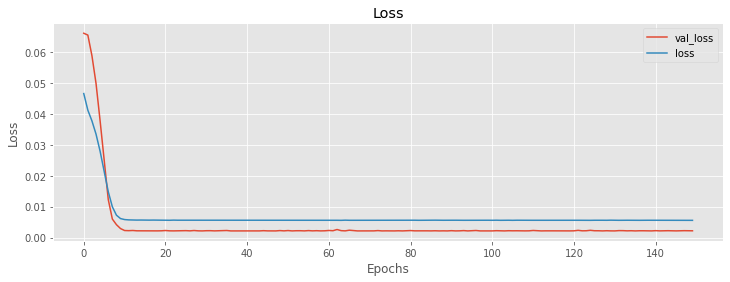

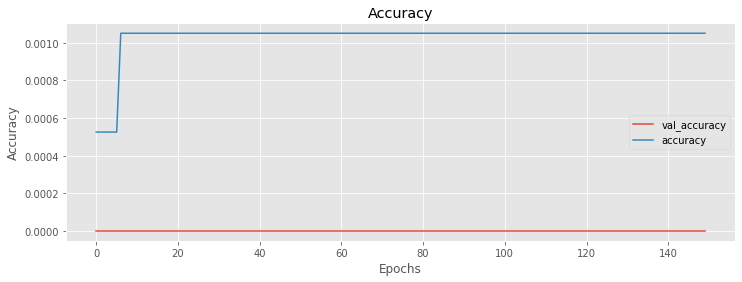

In [30]:
training_results(res)

In [31]:
### create predictions on the test set 
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1)) 
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs) 
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

print("Test set after reshaping:")
print('')
print(inputs)
print('')
print(inputs.shape)
print('')
print("Scaled inputs:")
print('')
print(inputs) 
print('')
print("Reshaped inputs:")
print('')
print(inputs)
print('')
print(inputs.shape)
print('')
print("Predicted BTC price: ", predicted_BTC_price)
print('')
print("Scaled predicted BTC price: ", predicted_BTC_price)
print('')

Test set after reshaping:

[[[0.49299003]]

 [[0.47337788]]

 [[0.40160903]]

 [[0.50648025]]

 [[0.40013989]]

 [[0.36529558]]

 [[0.4939292 ]]

 [[0.49409939]]

 [[0.47251261]]

 [[0.40079774]]

 [[0.50571736]]

 [[0.40230751]]

 [[0.35458246]]

 [[0.45503835]]

 [[0.49761909]]

 [[0.46576527]]

 [[0.40997006]]

 [[0.5054344 ]]

 [[0.39304703]]

 [[0.34448877]]

 [[0.43996389]]

 [[0.48634818]]

 [[0.46802928]]

 [[0.4089646 ]]

 [[0.52241528]]

 [[0.32052767]]

 [[0.35004986]]

 [[0.44285385]]

 [[0.47664887]]

 [[0.46864611]]]

(30, 1, 1)

Scaled inputs:

[[[0.49299003]]

 [[0.47337788]]

 [[0.40160903]]

 [[0.50648025]]

 [[0.40013989]]

 [[0.36529558]]

 [[0.4939292 ]]

 [[0.49409939]]

 [[0.47251261]]

 [[0.40079774]]

 [[0.50571736]]

 [[0.40230751]]

 [[0.35458246]]

 [[0.45503835]]

 [[0.49761909]]

 [[0.46576527]]

 [[0.40997006]]

 [[0.5054344 ]]

 [[0.39304703]]

 [[0.34448877]]

 [[0.43996389]]

 [[0.48634818]]

 [[0.46802928]]

 [[0.4089646 ]]

 [[0.52241528]]

 [[0.3205

In [32]:
### get evaluation of the model predictions 
model_evaluation = model.evaluate(inputs, predicted_BTC_price) 

print("Model evaluation is: ", model_evaluation)  
print('') 

30/30 [==============================] - 0s 62us/step
Model evaluation is:  [74107256.0, 0.0]



Visualize the results:



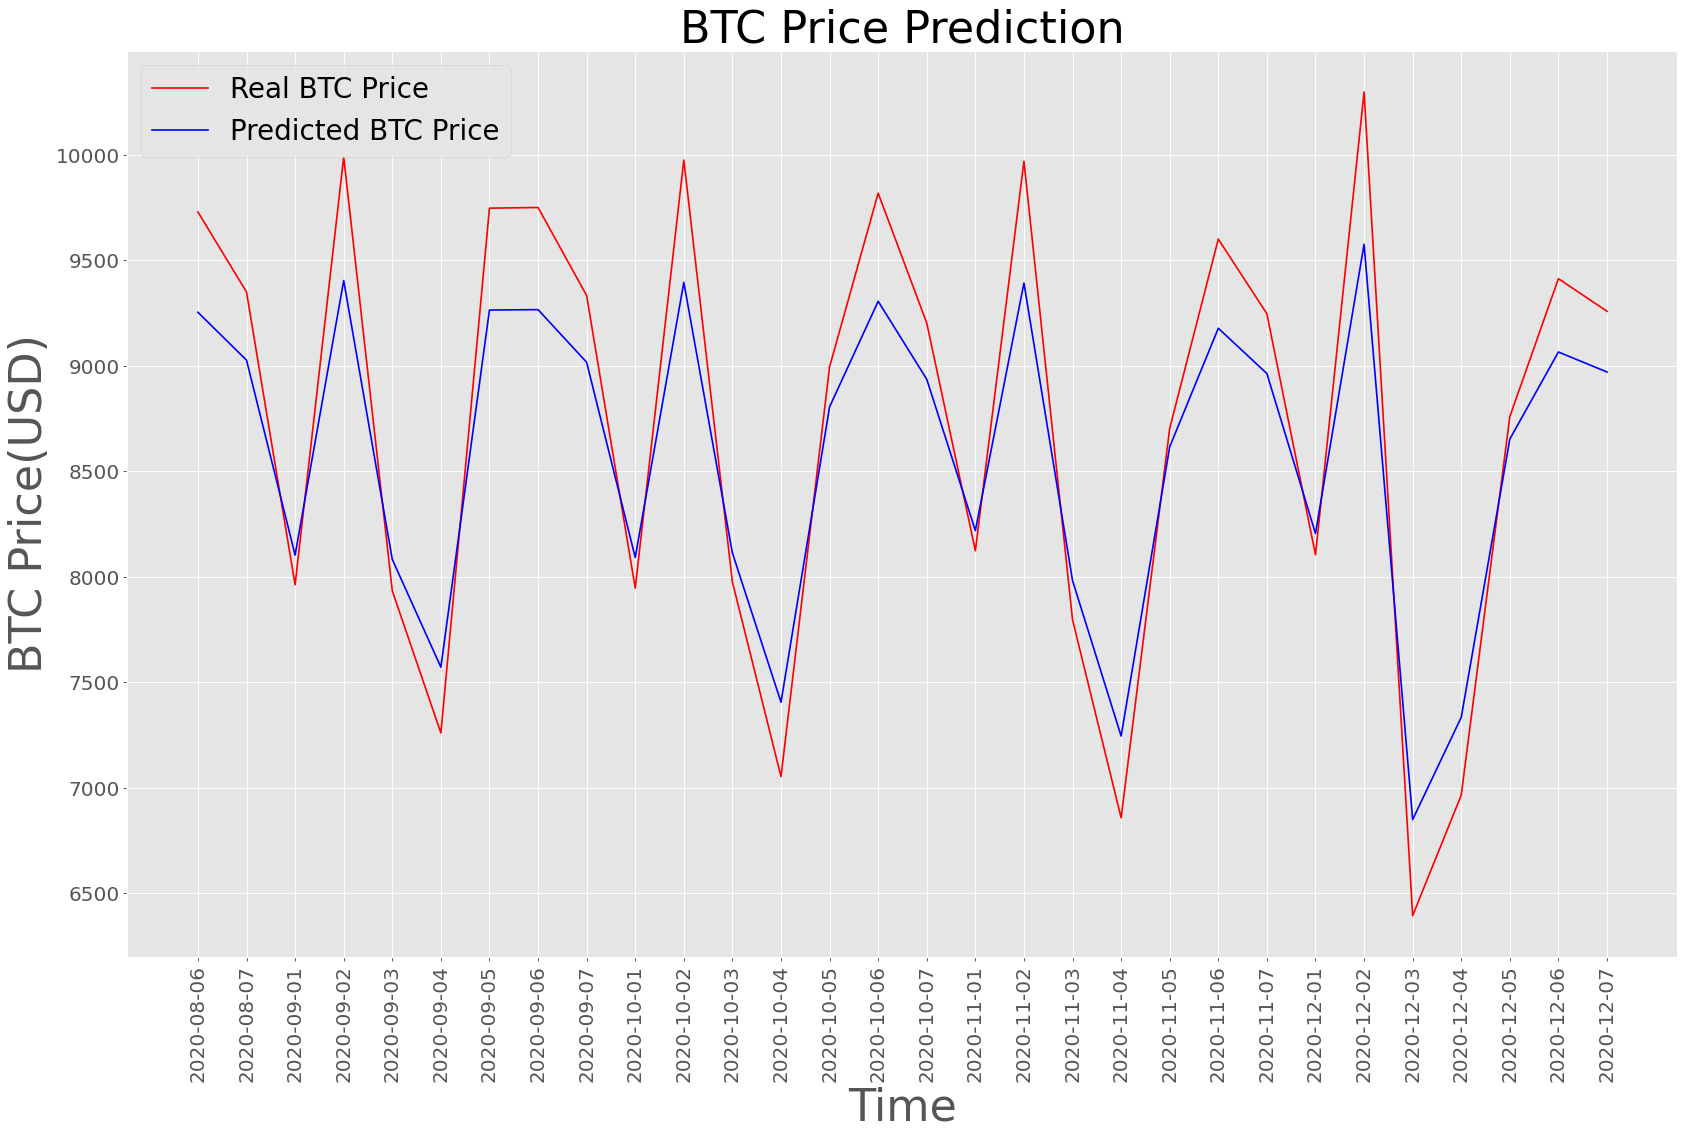

In [33]:
### visualize the results 
print("Visualize the results:") 
print('')

### plot the actual and predicted prices 
plt.figure(figsize =(25, 15), dpi =80, facecolor ='w', edgecolor ='k')
ax = plt.gca() 
plt.plot(test_set, color = 'red', label = "Real BTC Price") 
plt.plot(predicted_BTC_price, color = 'blue', label = "Predicted BTC Price") 
plt.title("BTC Price Prediction", fontsize = 40)

### reindex the 'df_test' dataframe 
df_test = df_test.reset_index() 
x = df_test.index

### set labels
labels = df_test['date']

### set xticks 
plt.xticks(x, labels, rotation = 'vertical')

### set fontsize for 'x' and 'y' ticks 
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
### set plot labels 
plt.xlabel('Time', fontsize = 40)
plt.ylabel('BTC Price(USD)', fontsize = 40)

### set plot legend
plt.legend(loc = 2, prop = {'size' : 25})  

### show the plot 
plt.show()    